## Preprocess data for training

### Load data

In [1]:
from pandas import read_csv

data = read_csv("../input/rainbow-store/VinIDRecruitChallenge_MLTrack_DataSet.csv")

### Make sure data is sorted by customer id

In [2]:
data = data.sort_values(by=['csn'])

### Check if there is any customer purchase at least twice in the same day

In [3]:
True in data.duplicated(subset=['csn', 'date'], keep=False).tolist()

False

### Features extraction from transaction info

transaction_info <- count of items in each group + quantity + price

In [4]:
from json import loads
from pickle import load

# loads clustered item groups
with open('../input/rainbow-store/cluster.pkl', 'rb') as file:
    cluster = load(file)
    groups = 38
    
def extract(info):
    inf = loads(info.replace("\'", "\""))
    features = [0 for group in range(groups)] # count number of items in each group
    count = 0 # total count
    price = 0 # total price
    for item in inf:
        quantity = item['salesquantity']
        count += quantity
        price += item['price']
        article = item['article']
        if article in cluster:
            features[cluster[article]] += quantity
    features.append(count)
    features.append(price)
    return features

### Make a dictionary containing data for each customer

dic <- {customer: {date: transaction_info}}

In [5]:
from datetime import datetime
from gc import collect

dic = {}
for index, row in data.iterrows():
    customer = row['csn']
    if customer not in dic:
        dic[customer] = {}
    dic[customer][datetime.strptime(row['date'], '%Y-%m-%d')] = extract(row['transaction_info'])
    
del data
collect()

0

### Visualize date data

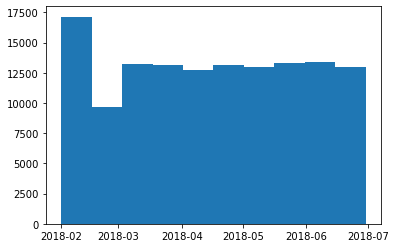

In [6]:
import matplotlib.pyplot as plt

dates = []
for customer in dic:
    for date in dic[customer]:
        dates.append(date)
plt.hist(dates)
plt.show()

Dataset was recorded from start of Feb until late Jun

### Transform data by month

transaction_info <- transaction_info + time different

dic2 <- {customer: {month: transaction_info}}

In [7]:
dic2 = {}
for customer in dic:
    dic2[customer] = {}
    for m in range(2, 7):
        dic2[customer][m] = []
    last_date = -1
    cus = dic[customer]
    for date in sorted(cus):
        m = date.month
        features = cus[date]
        
        # append time between purchases
        if last_date == -1: # first purchase
            features.append(0)
        else:
            features.append((date - last_date).days)
            
        dic2[customer][m].append(features)
        last_date = date

del dic
collect()

0

### Transform data into features and labels

features <- transaction_info in 2 months

label <- next month

In [8]:
features = []
labels = []
features_test = [] # data for prediction
customers = [] # list of customers

for customer in dic2:
    cus = dic2[customer]
    prev_2 = cus[2]
    prev_1 = cus[3]
    for m in range(4, 7):
        example = prev_2 + prev_1
        if len(example) > 0: # remove example in which there is no transaction
            features.append(example)
            prev_2 = prev_1
            prev_1 = cus[m]
            if len(prev_1) > 0:
                labels.append(1)
            else:
                labels.append(0)
     
    # prepare data for prediction
    example = cus[5] + cus[6]
    if len(example) > 0:
        features_test.append(example)
        customers.append(customer)

### Number of examples

### Save dataset

In [9]:
from pickle import dump

with open('data.pkl', 'wb') as file:
    dump([features, labels, features_test, customers], file, protocol=-1)